# FactSet Supply Chain Relationships

FactSet Supply Chain Relationships data is built to expose business relationship interconnections among companies globally. This feed provides access to the complex networks of companies' key customers, suppliers, competitors, and strategic partners, collected from annual filings, investor presentations, and press releases.
   
This notebook will introduce the Supply Chain tables and data contained within, while examining the Supply Chain of Intel Corp. 

## Notice
This example workbook provides queries in SQL formatted for MSSQL and sample python code. It may be necessary to adjust the query language to suit a different SQL DBMS. Sample queries and code should be viewed as possible examples of data calculations and are subject to change. The queries and code provided should be used as a guide to understand how the underlying data items can be used but are not guaranteed to represent the same methodology as the FactSet Workstation or other industry calculations. Queries cannot be guaranteed to be written for performance and/or efficiency.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import os


import sys
sys.path.append('../')
import utils.loadsql as loadsql
sys.path.append('/')

#Define Directory of SQL Queries
sql_path = './../SQL Queries/'

## Create DSN Connection

Enter a DSN associated with the MSSQL database containing FactSet Standard DataFeeds.

In [2]:
dsn = 'SDF'
cxn = pyodbc.connect('DSN={dsn_name}'.format(dsn_name = dsn))

## Supply Chain Coverage

### Coverage by Country

FactSet Supply Chain offers a universe of over 200,000 entities, across more than 200 countries. In the chart below, we can see the top 10 countries by coverage.

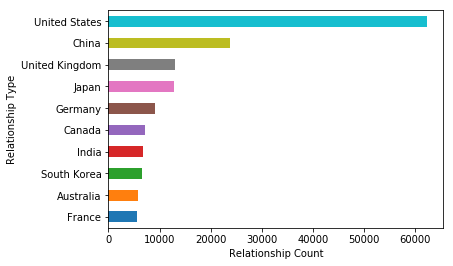

In [3]:
#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.1 Supply Chain Coverage by Country.sql')
                      ,show=0,connection=dsn)

country = pd.read_sql(q,cxn,index_col='country_desc')
country['company_count'].sort_values().tail(10).plot(kind='barh')
plt.ylabel('Relationship Type')
plt.xlabel('Relationship Count');

In [4]:
country.head(10)

,company_count
country_desc,
United States,62416
China,23764
United Kingdom,12932
Japan,12778
Germany,9019
Canada,7237
India,6843
South Korea,6505
Australia,5861


### Company Relationship Types

There are 13 types of normalized relationships contained within the Supply Chain DataFeed. To source these relationships, primary public sources such as SEC 10-K annual filings,
investor presentations, and press releases are leveraged.

In [5]:
#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.2 Supply Chain Coverage by Relationship Type.sql')
                      ,show=0,connection=dsn)

rel_type = pd.read_sql(q,cxn,index_col='relationship_type')
rel_type


,relationship_count
relationship_type,
Customer,504618
Competitor,301423
Supplier,192790
Partner - Research Collaboration,82086
Partner - Investors,79075
Partner - Equity Investment,77411
Partner - Joint Venture,47280
Partner - Distribution,29612
Partner - In-licensing,27696


## Uncovering Relationships

### Direct Relationships

A key value of the Supply Chain DataFeed is the ability to uncover the direct relationships that have been reported by a company as well as the reverse relationships in which they are named in other companies' filings. Using Intel, we can see the power the reverse relationship offers. Starting with the **ENT_SCR_RELATIONSHIPS** table, we'll first look to see how Intel lists their active relationships in their filings by setting Intel to our **source_factset_entity_id**.

Key columns in the **ENT_SCR_RELATIONSHIPS** table:

* **id**: Unique identifier representing a relationship.
* **rel_type**: Code denoting the type of relationship as reported by the source_factset_entity_id.
* **source_factset_entity_id**: Unique FactSet-generated identifier assigned to the company that reported the relationship.
* **target_factset_entity_id**: Unique FactSet-generated identifier assigned to the company which was reported as being related to the source company.
* **start_date**: Date the record was first published.
* **end_date**: Date the record was terminated. A null end_date indicate the relationship is considered current.
* **revenue_pct**: Percentage of its revenue that the source company derived from this relationship in the reporting period. This field is only applicable to relationships reported as Customer and only then for those cases where the reporting company provides a percentage.




In [6]:
ticker = 'INTC-US'

#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.3 Relationships by Source.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

source = pd.read_sql(q,cxn,index_col='id')
source.head(10)


,rel_type_desc,source_entity,target_entity,start_date,end_date,revenue_pct
id,,,,,,
CUST-103991020,Customer,Intel Corp.,"Dell Technologies, Inc.",2018-02-28 08:00:00,None,16.0
CUST-26654499,Customer,Intel Corp.,Lenovo Group Ltd.,2019-02-07 08:00:00,None,12.0
CUST-82347515,Customer,Intel Corp.,"HP, Inc.",2018-02-28 08:00:00,None,11.0
PARTN-121621874-EINVEST,Partner - Equity Investment,Intel Corp.,McAfee LLC,2018-02-27 14:00:00,None,NaN
SUPPL-137603375,Supplier,Intel Corp.,"Computech International, Inc.",2019-02-22 08:00:00,None,NaN
CUST-137603588,Customer,Intel Corp.,National Express Group Plc,2019-02-22 08:00:00,None,NaN
CUST-137042119,Customer,Intel Corp.,Bridgford Foods Corp.,2019-02-07 08:00:00,None,NaN
CUST-121656837,Customer,Intel Corp.,"Arrow Electronics, Inc.",2018-02-28 08:00:00,None,NaN
SUPPL-137611591,Supplier,Intel Corp.,DISCO Corp.,2019-02-22 08:00:00,None,NaN


We get back around 80 relationships, as identified by Intel. In cases where a Customer has reported a revenue percentage as it relates to the relationship, that will also be included. In the below chart, we can see the breakdown of the various relationship types:

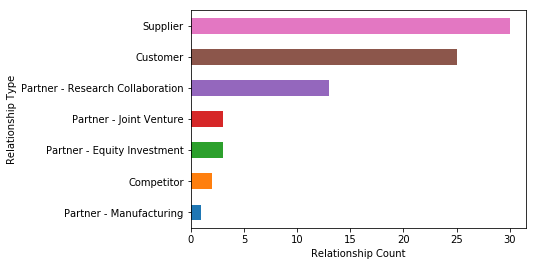

In [7]:
source.reset_index().groupby(['rel_type_desc'])['id'].count().sort_values().plot(kind='barh')
plt.ylabel('Relationship Type')
plt.xlabel('Relationship Count');

### Reverse Relationships

While being able to uncover almost 80 relationships that Intel is involved in is certainly powerful and useful to better understand their supply chain, if we take advantage of the reverse relationships that the Supply Chain DataFeed provides, we can expand our mappings over 5-fold to more than 450 relationships. In the query below, Intel is set as the **target_factset_entity_id** within the **ENT_SCR_RELATIONSHIPS** table.

In [8]:
ticker = 'INTC-US'

#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.4 Relationships by Target.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

target = pd.read_sql(q,cxn,index_col='id')
target.head(10)

,rel_type_desc,source_name,target_name,start_date,end_date,revenue_pct
id,,,,,,
CUST-115599585,Customer,Aquantia Corp.,Intel Corp.,2019-03-28 14:00:00,None,49.00
CUST-140752373,Customer,KoMiCo Ltd.,Intel Corp.,2019-05-02 14:00:00,None,30.70
CUST-34449844,Customer,"Shinko Electric Industries Co., Ltd.",Intel Corp.,2018-09-25 14:00:00,None,27.50
CUST-34396253,Customer,"IBIDEN Co., Ltd.",Intel Corp.,2019-06-24 14:00:00,None,21.36
CUST-19871229,Customer,"KMG Chemicals, Inc.",Intel Corp.,2019-04-05 14:00:00,None,20.00
CUST-60095281,Customer,"FormFactor, Inc.",Intel Corp.,2019-03-12 14:00:00,None,19.00
CUST-33040567,Customer,Tokyo Electron Ltd.,Intel Corp.,2018-08-29 08:00:00,None,16.01
CUST-118412746,Customer,"Synopsys, Inc.",Intel Corp.,2018-12-27 08:00:00,None,15.40
CUST-102762313,Customer,"Applied Materials, Inc.",Intel Corp.,2018-12-20 08:00:00,None,11.00


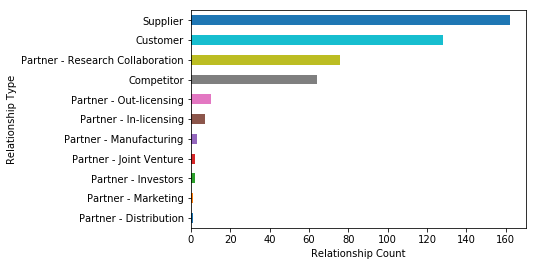

In [9]:
target.reset_index().groupby(['rel_type_desc'])['id'].count().sort_values().plot(kind='barh')
plt.ylabel('Relationship Type')
plt.xlabel('Relationship Count');

### Simplifying the Process
The **ENT_SCR_RELATIONSHIPS** table provides the entirety of relationships offered by Supply Chain. If, however, you only cared to see Supplier and Customer relationships, the **ENT_SCR_SUPPLY_CHAIN** table provides both the direct and reverse parings in a single view.  Below is a breakdown of some of the key columns contained within the table:

* **id**: Unique identifier representing a relationship.
* **supplier_factset_entity_id**: Unique FactSet-generated identifier assigned to the company that is determined to be the supplier.
* **customer_factset_entity_id**: Unique FactSet-generated identifier assigned to the company that is determined to be the customer.
* **source_factset_entity_id**: Unique FactSet-generated entity identifier assigned to the company that reported the relationship. This can be used to extrapolate whether the record was a direct or reverse customer relationship.

While the data overlaps between the two tables, depending on the desired output, both provide valuable ways to query the data. Let's take a look at the output from **ENT_SCR_SUPPLY_CHAIN** to see this in action. The source_factset_entity_id is provided as the **source_name** in the output below which identifies who reported on the relationship. 

In [10]:
ticker = 'INTC-US'

#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.5 Identifying Suppliers and Customers.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

ent_scr = pd.read_sql(q,cxn,index_col='id')
ent_scr.head(10)


,supplier_name,customer_name,source_name,start_date,end_date,revenue_pct
id,,,,,,
CUST-115599585,Aquantia Corp.,Intel Corp.,Aquantia Corp.,2019-03-28 14:00:00,None,49.00
CUST-140752373,KoMiCo Ltd.,Intel Corp.,KoMiCo Ltd.,2019-05-02 14:00:00,None,30.70
CUST-34449844,"Shinko Electric Industries Co., Ltd.",Intel Corp.,"Shinko Electric Industries Co., Ltd.",2018-09-25 14:00:00,None,27.50
CUST-34396253,"IBIDEN Co., Ltd.",Intel Corp.,"IBIDEN Co., Ltd.",2019-06-24 14:00:00,None,21.36
CUST-19871229,"KMG Chemicals, Inc.",Intel Corp.,"KMG Chemicals, Inc.",2019-04-05 14:00:00,None,20.00
CUST-60095281,"FormFactor, Inc.",Intel Corp.,"FormFactor, Inc.",2019-03-12 14:00:00,None,19.00
CUST-33040567,Tokyo Electron Ltd.,Intel Corp.,Tokyo Electron Ltd.,2018-08-29 08:00:00,None,16.01
CUST-103991020,Intel Corp.,"Dell Technologies, Inc.",Intel Corp.,2018-02-28 08:00:00,None,16.00
CUST-118412746,"Synopsys, Inc.",Intel Corp.,"Synopsys, Inc.",2018-12-27 08:00:00,None,15.40


It's worth noting that in cases where the customer and supplier both report on a relationship, duplicate pairings can appear as can be seen in the subsequent output.  These can either be removed if preferred or weighted stronger in your analysis as both companies deemed the relationship important enough to include in their filings.

In [11]:
#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.6 Duplicate Relationships.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

scr_dupes = pd.read_sql(q,cxn,index_col='id')
scr_dupes

,supplier_factset_entity_id,supplier_name,customer_name,source_name,start_date,end_date,revenue_pct
id,,,,,,,
CUST-102762313,000C7R-E,"Applied Materials, Inc.",Intel Corp.,"Applied Materials, Inc.",2018-12-20 08:00:00,None,11.0
SUPPL-137612901,000C7R-E,"Applied Materials, Inc.",Intel Corp.,Intel Corp.,2019-02-22 08:00:00,None,NaN


## Relationship Keywords
In addition to defining relationships that exist between two companies, FactSet's Supply Chain Relationships supplies search-friendly keywords to provide context to the relationship. 10 columns are provided to allow for flexibility to the analysts when combing through sources to find the correct words to identify the relationship details.

This data can all be found in the **ENT_SCR_RELATIONSHIPS_KEYWORD** table.  Please see the key table items and definitions:

* **keyword_id**: Unique identifier for the relationship keyword record.
* **source_entity_keyword**: Unique FactSet-generated identifier assigned to the company that is determined to be the supplier.
* **target_entity_keyword**: Unique FactSet-generated identifier assigned to the company that is determined to be the customer.
* **relationship_keyword1-10**: Keyword defined for the relationship. 10 columns available however not all relationships will have values in all slots in the keyword record.

In [12]:
ticker = 'INTC-US'

#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.7 Relationship Keywords.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

keywords = pd.read_sql(q,cxn,index_col=['id','keyword_id'])
keywords.head(5)


,,rel_type_desc,source_name,source_entity_keyword,target_name,target_entity_keyword,relationship_keyword1,relationship_keyword2
id,keyword_id,,,,,,,
CUST-103991020,CUST-103991020-103991021,Customer,Intel Corp.,Intel,"Dell Technologies, Inc.",Dell Inc,processors,None
CUST-26654499,CUST-26654499-26654500,Customer,Intel Corp.,Intel,Lenovo Group Ltd.,Lenovo,processors,None
CUST-82347515,CUST-82347515-82347516,Customer,Intel Corp.,Intel,"HP, Inc.",HP,processors,None
SUPPL-137614433,SUPPL-137614433-137614434,Supplier,Intel Corp.,Intel,Veolia Environnement SA,Veolia,waste management,None
SUPPL-137614109,SUPPL-137614109-137614110,Supplier,Intel Corp.,Intel,Tokyo Electron Ltd.,TEL,thermal processing systems,deposition systems


### Non-Unique Relationships
It's important to note that cases can arise where a relationship type between two companies can house multiple distinct relationships. For example, with the Supplier relationship between Intel Corp. and Nokia Oyj, a separate Supplier relationship exists for the Cloud and 5G businesses. In those cases, a single **id** will be used but the detailed breakdown of the distinct relationships can be identified with the **keyword_id** via the ENT_SCR_RELATIONSHIPS_KEYWORD table. We'll view the Nokia, Intel example among others to see what this data looks like.

In [13]:
ticker = 'INTC-US'

#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.8 Identifying Non-Unique Relationships.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

non_uniques = pd.read_sql(q,cxn,index_col=['id','keyword_id'])
non_uniques.head(10)

rel_type_desc  \
id                     keyword_id                                                           
SUPPL-1902812          SUPPL-1902812-141401362                                   Supplier   
                       SUPPL-1902812-66958                                       Supplier   
SUPPL-126892826        SUPPL-126892826-126892827                                 Supplier   
                       SUPPL-126892826-139810913                                 Supplier   
SUPPL-111537419        SUPPL-111537419-111537420                                 Supplier   
                       SUPPL-111537419-142721013                                 Supplier   
PARTN-73182303-RESCOLB PARTN-73182303-RESCOLB-105361104  Partner - Research Collaboration   
                       PARTN-73182303-RESCOLB-105373414  Partner - Research Collaboration   
                       PARTN-73182303-RESCOLB-73182304   Partner - Research Collaboration   
                       PARTN-73182303-RESCOLB-87401494   Partner - Research Collaboration   

                                                                     source_name  \
id                     keyword_id                                                  
SUPPL-1902812          SUPPL-1902812-141401362                         Nokia Oyj   
                       SUPPL-1902812-66958                             Nokia Oyj   
SUPPL-126892826        SUPPL-126892826-126892827                        ICON plc   
                       SUPPL-126892826-139810913                        ICON plc   
SUPPL-111537419        SUPPL-111537419-111537420         Adlink Technology, Inc.   
                       SUPPL-111537419-142721013         Adlink Technology, Inc.   
PARTN-73182303-RESCOLB PARTN-73182303-RESCOLB-105361104     General Electric Co.   
                       PARTN-73182303-RESCOLB-105373414     General Electric Co.   
                       PARTN-73182303-RESCOLB-73182304      General Electric Co.   
                       PARTN-73182303-RESCOLB-87401494      General Electric Co.   

                                                         target_name  \
id                     keyword_id                                      
SUPPL-1902812          SUPPL-1902812-141401362           Intel Corp.   
                       SUPPL-1902812-66958               Intel Corp.   
SUPPL-126892826        SUPPL-126892826-126892827         Intel Corp.   
                       SUPPL-126892826-139810913         Intel Corp.   
SUPPL-111537419        SUPPL-111537419-111537420         Intel Corp.   
                       SUPPL-111537419-142721013         Intel Corp.   
PARTN-73182303-RESCOLB PARTN-73182303-RESCOLB-105361104  Intel Corp.   
                       PARTN-73182303-RESCOLB-105373414  Intel Corp.   
                       PARTN-73182303-RESCOLB-73182304   Intel Corp.   
                       PARTN-73182303-RESCOLB-87401494   Intel Corp.   

                                                                   relationship_keyword1  \
id                     keyword_id                                                          
SUPPL-1902812          SUPPL-1902812-141401362                                 Cloud RAN   
                       SUPPL-1902812-66958                                 5G technology   
SUPPL-126892826        SUPPL-126892826-126892827         Intel Pharma Analytics Platform   
                       SUPPL-126892826-139810913                               agreement   
SUPPL-111537419        SUPPL-111537419-111537420                         Vortex Edge PMQ   
                       SUPPL-111537419-142721013                                 ROS 2.0   
PARTN-73182303-RESCOLB PARTN-73182303-RESCOLB-105361104                    Ecomagination   
                       PARTN-73182303-RESCOLB-105373414             GE Digital Ecosystem   
                       PARTN-73182303-RESCOLB-73182304     Intel-GE Care Innovations LLC   
                       PARTN-73182303-RESCOLB-87401494                   

## Ranking Relationships
To provide context on the importance of a relationship to a company, the **ENT_SCR_RELEVANCE_RANK** table includes the following values:

* **Ranking**: Integer value between 1 and 999 representing the calculated relative importance of the relationship to the ranked company in comparison to all other relationships for that ranked company.
* **Grade**: Integer value between 1 and 10,000 indicating the relevance factors' grade for this record.
 
Relevance **ranking** is determined by sorting the **grades** resulting from a calculation of a set of factors. A ranking of 1 is best and a higher grade results in a better ranking. Factors for creating the grade include whether the company being viewed was the discloser of the relationship, what percentage of the supplier's revenue is represented by the customer, as well as various types of metadata concerning the two companies involved. 

Both suppliers and customers are ranked together, however the grade can be used to create custom rankings.

To query the Relevance Rank table for a specific company, utilize the **ranked_factset_entity_id** field. See output for the top 10 ranked relationships for Intel.

In [14]:
ticker = 'INTC-US'

#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.9 Relationship Relevance Rank.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

rel_rank = pd.read_sql(q,cxn,index_col=['ranked_entity_name'])
rel_rank.head(10)

,supplier_name,customer_name,source_name,ranking,grade,customer_revenue_pct
ranked_entity_name,,,,,,
Intel Corp.,Intel Corp.,Lenovo Group Ltd.,Intel Corp.,1,20,12.00
Intel Corp.,Intel Corp.,"HP, Inc.",Intel Corp.,2,19,11.00
Intel Corp.,"Applied Materials, Inc.",Intel Corp.,Intel Corp.,3,17,11.00
Intel Corp.,Intel Corp.,"Arrow Electronics, Inc.",Intel Corp.,3,17,NaN
Intel Corp.,Lam Research Corp.,Intel Corp.,Intel Corp.,3,17,10.00
Intel Corp.,Intel Corp.,"Dell Technologies, Inc.",Intel Corp.,3,17,16.00
Intel Corp.,"Micron Technology, Inc.",Intel Corp.,Intel Corp.,3,17,NaN
Intel Corp.,"Cloudera, Inc.",Intel Corp.,"Cloudera, Inc.",4,15,2.96
Intel Corp.,Intel Corp.,Lenovo Group Ltd.,Lenovo Group Ltd.,5,14,12.00


### Creating Custom Rankings
As noted, custom rankings can easily be created. This can be useful when wanting to simply rank only customer relationships for example. Another reason to create a custom ranking is to remove duplicate pairings that occur when a customer and supplier both report on a relationship. In the next example, we rank only customers of Intel and remove duplicate relationships by taking the average grade when the scenario arises.

In [15]:
ticker = 'INTC-US'

#loadsql is a cover function used to retrieve SQL queries from a directory
q = loadsql.get_sql_q(os.path.join(sql_path,'1.1.10 Creating Custom Rankings.sql')
                      ,show=0,connection=dsn).format(sym=ticker)

custom_rank = pd.read_sql(q,cxn,index_col=['ranked_entity_name'])
custom_rank.head(10)

,supplier_name,customer_name,grade,rank,customer_revenue_pct
ranked_entity_name,,,,,
Intel Corp.,Intel Corp.,Lenovo Group Ltd.,20,1,12.0
Intel Corp.,Intel Corp.,"HP, Inc.",19,2,11.0
Intel Corp.,Intel Corp.,"Arrow Electronics, Inc.",17,3,NaN
Intel Corp.,Intel Corp.,"Dell Technologies, Inc.",17,3,16.0
Intel Corp.,Intel Corp.,Lenovo Group Ltd.,14,5,12.0
Intel Corp.,Intel Corp.,"Arrow Electronics, Inc.",13,6,NaN
Intel Corp.,Intel Corp.,"CSP, Inc.",13,6,NaN
Intel Corp.,Intel Corp.,"HP, Inc.",13,6,11.0
Intel Corp.,Intel Corp.,Lattice Semiconductor Corp.,13,6,NaN


## Next Steps

* **Please check out these notebooks for additional information on the FactSet Supply Chain Relationships DataFeed:** 
    * 1.2 Linking Market IDs to FactSet Entity IDs
    * 1.3 Mapping Customers and Suppliers to Tradable Securities


* **Documentation for the feeds discussed above can be found within the** [Open:FactSet Marketplace](https://open.factset.com/en-us)
    * [FactSet Supply Chain Relationships](https://open.factset.com/products/factset-supply-chain-relationships/en-us) 
 
 
* **Please direct any training requests or questions to your CTS Implementation Specialist.**